<a href="https://colab.research.google.com/github/BehnamSherafat/Generating-Deterioration-Curves-for-Culverts-using-Machin-Learning/blob/main/PreProcessUtahCulverts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from numpy import mean
from numpy import std
from sympy import S, symbols, printing
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

In [ ]:
sns.set(rc={'figure.figsize':(35,15)})

In [ ]:
# Upload Vermont Culvert Dataset
UtahCulverts = pd.read_excel("Utah_Culverts_272_Inspection_final.xlsx")
UtahCulverts.head(5)

,Row,CvtID,RD_Route_ID,RD_Route_Num,RD_Ref_Post,RD_Accum_Mileage,RD_Average_AADT,RD_Latitude,RD_Longitude,RD_Highwy,...,WT_Flow,Road_Importance,Span_Importance,Drain_Importance,Importance_Modifier,Age,Maint_Rtg,Brl_Rtng,Wtrwy_Rtng,Rdway_Condition
0,272,360H-006-0024-05100,SR-006,6,25,24.51,401,39.08967,-113.60688,Undivided,...,Intermittent,0.91,1.00,0.91,0.83,55,6,7,6,Good
1,271,360H-006-0055-00200,SR-006,6,55,55.02,399,39.12852,-113.10622,Undivided,...,Intermittent,0.91,0.91,0.91,0.75,23,7,7,7,Fair
2,270,360H-006-0075-09800,SR-006,6,76,75.98,399,39.30673,-112.79398,Undivided,...,Intermittent,0.91,1.10,0.91,0.91,33,6,6,8,Good
3,269,360H-006-0108-03900,SR-006,6,108,108.39,1160,39.56523,-112.34710,Undivided,...,Intermittent,1.00,1.10,0.91,1.00,41,7,8,7,Good
4,268,360H-006-0124-06200,SR-006,6,125,124.62,869,39.75590,-112.18078,Undivided,...,Intermittent,1.00,1.10,0.91,1.00,41,8,8,8,Good


In [ ]:
# rows_w_age = UtahCulverts[~UtahCulverts['Age_No_Fill'].isnull()]
# rows_w_age
# sns.boxplot(x="Maint\nRtg", y="Age_No_Fill", data=rows_w_age)

In [ ]:
UtahCulverts.loc[UtahCulverts['Maint_Rtg'] == 9, ['Age']] -= 20
UtahCulverts.loc[UtahCulverts['Maint_Rtg'] == 6, ['Age']] -= 9
UtahCulverts.loc[UtahCulverts['Maint_Rtg'] == 0, ['Age']] += 4

In [ ]:
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 9, ['Age']] -= 2
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 7, ['Age']] -= 5
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 6, ['Age']] -= 3
UtahCulverts.loc[UtahCulverts['Brl_Rtng'] == 3, ['Age']] += 4

In [ ]:
UtahCulverts.loc[UtahCulverts['Wtrwy_Rtng'] == 9, ['Age']] -= 2
UtahCulverts.loc[UtahCulverts['Wtrwy_Rtng'] == 4, ['Age']] += 1

In [ ]:
# Remove Unnecessary Columns
UtahCulverts.drop(['Row', 'CvtID', 'RD_Route_Num','RD_Ref_Post','RD_Accum_Mileage','RD_Latitude','RD_Longitude','Rdway_Condition'], axis=1, inplace=True)

In [ ]:
# Fill Missing Values for Road Features (RD_)
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_Route_ID'] = impute_size.fit_transform(UtahCulverts[['RD_Route_ID']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['RD_Average_AADT'] = impute_size.fit_transform(UtahCulverts[['RD_Average_AADT']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_Highwy'] = impute_size.fit_transform(UtahCulverts[['RD_Highwy']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['RD_Rdwy_Cvr_in'] = impute_size.fit_transform(UtahCulverts[['RD_Rdwy_Cvr_in']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_Surface_Type'] = impute_size.fit_transform(UtahCulverts[['RD_Surface_Type']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_Region'] = impute_size.fit_transform(UtahCulverts[['RD_Region']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['RD_ShldrSurfacType'] = impute_size.fit_transform(UtahCulverts[['RD_ShldrSurfacType']])


# Fill Missing Values for Culvert Features (CV_)
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Drn_Type'] = impute_size.fit_transform(UtahCulverts[['CV_Drn_Type']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_IltEndTrtmnt'] = impute_size.fit_transform(UtahCulverts[['CV_IltEndTrtmnt']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_IltSide'] = impute_size.fit_transform(UtahCulverts[['CV_IltSide']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_OtltEndTrtmnt'] = impute_size.fit_transform(UtahCulverts[['CV_OtltEndTrtmnt']])

impute_size = SimpleImputer(strategy="most_frequent") 
UtahCulverts['CV_OtltSide'] = impute_size.fit_transform(UtahCulverts[['CV_OtltSide']])

impute_size = SimpleImputer(strategy="most_frequent") 
UtahCulverts['CV_Brl_Count'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Count']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['CV_Brl_Length_ft'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Length_ft']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Barrel_Material'] = impute_size.fit_transform(UtahCulverts[['CV_Barrel_Material']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Brl_Shape'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Shape']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Span_in'] = impute_size.fit_transform(UtahCulverts[['CV_Span_in']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Brl_Rise'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Rise']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['CV_Brl_Coat_Type'] = impute_size.fit_transform(UtahCulverts[['CV_Brl_Coat_Type']])


# Fill Missing Values for Soil Features (SL_)
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Envlp_Type'] = impute_size.fit_transform(UtahCulverts[['SL_Envlp_Type']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_EnvlpMoist'] = impute_size.fit_transform(UtahCulverts[['SL_EnvlpMoist']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Drainage_Class'] = impute_size.fit_transform(UtahCulverts[['SL_Drainage_Class']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['SL_Moisture'] = impute_size.fit_transform(UtahCulverts[['SL_Moisture']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['SL_pH'] = impute_size.fit_transform(UtahCulverts[['SL_pH']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="mean") 
UtahCulverts['SL_Elec_Conductivity'] = impute_size.fit_transform(UtahCulverts[['SL_Elec_Conductivity']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Surface_Texture'] = impute_size.fit_transform(UtahCulverts[['SL_Surface_Texture']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Flooding_Frequency'] = impute_size.fit_transform(UtahCulverts[['SL_Flooding_Frequency']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_UpstrmBnkProtct'] = impute_size.fit_transform(UtahCulverts[['SL_UpstrmBnkProtct']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_DnstrmBnkProtct'] = impute_size.fit_transform(UtahCulverts[['SL_DnstrmBnkProtct']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_VegIndx'] = impute_size.fit_transform(UtahCulverts[['SL_VegIndx']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Revegetation_Zone'] = impute_size.fit_transform(UtahCulverts[['SL_Revegetation_Zone']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['SL_Geologic_Zone'] = impute_size.fit_transform(UtahCulverts[['SL_Geologic_Zone']])


# Fill Missing Values for Water Features (WT_)
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['WT_Flow'] = impute_size.fit_transform(UtahCulverts[['WT_Flow']])


# Fill Missing Values for Importance Features
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Road_Importance'] = impute_size.fit_transform(UtahCulverts[['Road_Importance']])

# Fill Missing Values for Condition Features
impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Maint_Rtg'] = impute_size.fit_transform(UtahCulverts[['Maint_Rtg']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Brl_Rtng'] = impute_size.fit_transform(UtahCulverts[['Brl_Rtng']])

impute_size = SimpleImputer(missing_values=np.nan, strategy="most_frequent") 
UtahCulverts['Wtrwy_Rtng'] = impute_size.fit_transform(UtahCulverts[['Wtrwy_Rtng']])

In [ ]:
# Modify Type of each Column
UtahCulverts["RD_Average_AADT"] = UtahCulverts["RD_Average_AADT"].astype(int)
UtahCulverts["RD_Rdwy_Cvr_in"] = UtahCulverts["RD_Rdwy_Cvr_in"].astype(int)
UtahCulverts["RD_Region"] = UtahCulverts["RD_Region"].astype(int)
UtahCulverts["CV_Brl_Count"] = UtahCulverts["CV_Brl_Count"].astype(int)
UtahCulverts["CV_Brl_Length_ft"] = UtahCulverts["CV_Brl_Length_ft"].astype(int)
UtahCulverts["CV_Span_in"] = UtahCulverts["CV_Span_in"].astype(int)
UtahCulverts["CV_Brl_Rise"] = UtahCulverts["CV_Brl_Rise"].astype(int)
UtahCulverts["Age"] = UtahCulverts["Age"].astype(int)
UtahCulverts["Maint_Rtg"] = UtahCulverts["Maint_Rtg"].astype(int)
UtahCulverts["Brl_Rtng"] = UtahCulverts["Brl_Rtng"].astype(int)
UtahCulverts["Wtrwy_Rtng"] = UtahCulverts["Wtrwy_Rtng"].astype(int)

UtahCulverts['RD_Route_ID'] = UtahCulverts['RD_Route_ID'].astype('category')
UtahCulverts['RD_Highwy'] = UtahCulverts['RD_Highwy'].astype('category')                                                              
UtahCulverts['RD_Surface_Type'] = UtahCulverts['RD_Surface_Type'].astype('category')                                                              
UtahCulverts['RD_ShldrSurfacType'] = UtahCulverts['RD_ShldrSurfacType'].astype('category')                                                              
UtahCulverts['CV_Drn_Type'] = UtahCulverts['CV_Drn_Type'].astype('category')                                                              
UtahCulverts['CV_IltEndTrtmnt'] = UtahCulverts['CV_IltEndTrtmnt'].astype('category')                                                              
UtahCulverts['CV_IltSide'] = UtahCulverts['CV_IltSide'].astype('category')                                                              
UtahCulverts['CV_OtltEndTrtmnt'] = UtahCulverts['CV_OtltEndTrtmnt'].astype('category')                                                              
UtahCulverts['CV_OtltSide'] = UtahCulverts['CV_OtltSide'].astype('category')                                                              
UtahCulverts['CV_Barrel_Material'] = UtahCulverts['CV_Barrel_Material'].astype('category')  
UtahCulverts['CV_Brl_Shape'] = UtahCulverts['CV_Brl_Shape'].astype('category')                                                            
UtahCulverts['CV_Brl_Coat_Type'] = UtahCulverts['CV_Brl_Coat_Type'].astype('category')                                                                                                                           
UtahCulverts['SL_Envlp_Type'] = UtahCulverts['SL_Envlp_Type'].astype('category')
UtahCulverts['SL_EnvlpMoist'] = UtahCulverts['SL_EnvlpMoist'].astype('category')
UtahCulverts['SL_Drainage_Class'] = UtahCulverts['SL_Drainage_Class'].astype('category')
UtahCulverts['SL_Surface_Texture'] = UtahCulverts['SL_Surface_Texture'].astype('category')
UtahCulverts['SL_Flooding_Frequency'] = UtahCulverts['SL_Flooding_Frequency'].astype('category')
UtahCulverts['SL_UpstrmBnkProtct'] = UtahCulverts['SL_UpstrmBnkProtct'].astype('category')
UtahCulverts['SL_DnstrmBnkProtct'] = UtahCulverts['SL_DnstrmBnkProtct'].astype('category')
UtahCulverts['SL_VegIndx'] = UtahCulverts['SL_VegIndx'].astype('category')
UtahCulverts['SL_Revegetation_Zone'] = UtahCulverts['SL_Revegetation_Zone'].astype('category')
UtahCulverts['SL_Geologic_Zone'] = UtahCulverts['SL_Geologic_Zone'].astype('category')
UtahCulverts['WT_Flow'] = UtahCulverts['WT_Flow'].astype('category')


In [ ]:
## Second Approach (Mapping Column Values to Numbers)
labels = UtahCulverts['RD_Route_ID'].astype('category').cat.categories.tolist()
replace_map_comp = {'RD_Route_ID' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['RD_Highwy'].astype('category').cat.categories.tolist()
replace_map_comp = {'RD_Highwy' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['RD_Surface_Type'].astype('category').cat.categories.tolist()
replace_map_comp = {'RD_Surface_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['RD_ShldrSurfacType'].astype('category').cat.categories.tolist()
replace_map_comp = {'RD_ShldrSurfacType' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_Drn_Type'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_Drn_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_IltEndTrtmnt'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_IltEndTrtmnt' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_IltSide'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_IltSide' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_OtltEndTrtmnt'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_OtltEndTrtmnt' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_OtltSide'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_OtltSide' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_Barrel_Material'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_Barrel_Material' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_Brl_Shape'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_Brl_Shape' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['CV_Brl_Coat_Type'].astype('category').cat.categories.tolist()
replace_map_comp = {'CV_Brl_Coat_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_Drainage_Class'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_Drainage_Class' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_Surface_Texture'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_Surface_Texture' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_Flooding_Frequency'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_Flooding_Frequency' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_Envlp_Type'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_Envlp_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_EnvlpMoist'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_EnvlpMoist' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_UpstrmBnkProtct'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_UpstrmBnkProtct' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_DnstrmBnkProtct'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_DnstrmBnkProtct' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_VegIndx'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_VegIndx' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_Revegetation_Zone'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_Revegetation_Zone' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['SL_Geologic_Zone'].astype('category').cat.categories.tolist()
replace_map_comp = {'SL_Geologic_Zone' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

labels = UtahCulverts['WT_Flow'].astype('category').cat.categories.tolist()
replace_map_comp = {'WT_Flow' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
UtahCulverts.replace(replace_map_comp, inplace=True)

['CV_Drn_Type',
 'Drain_Importance',
 'SL_Flooding_Frequency',
 'RD_Highwy',
 'CV_Brl_Shape',
 'Span_Importance',
 'SL_EnvlpMoist',
 'CV_IltSide']

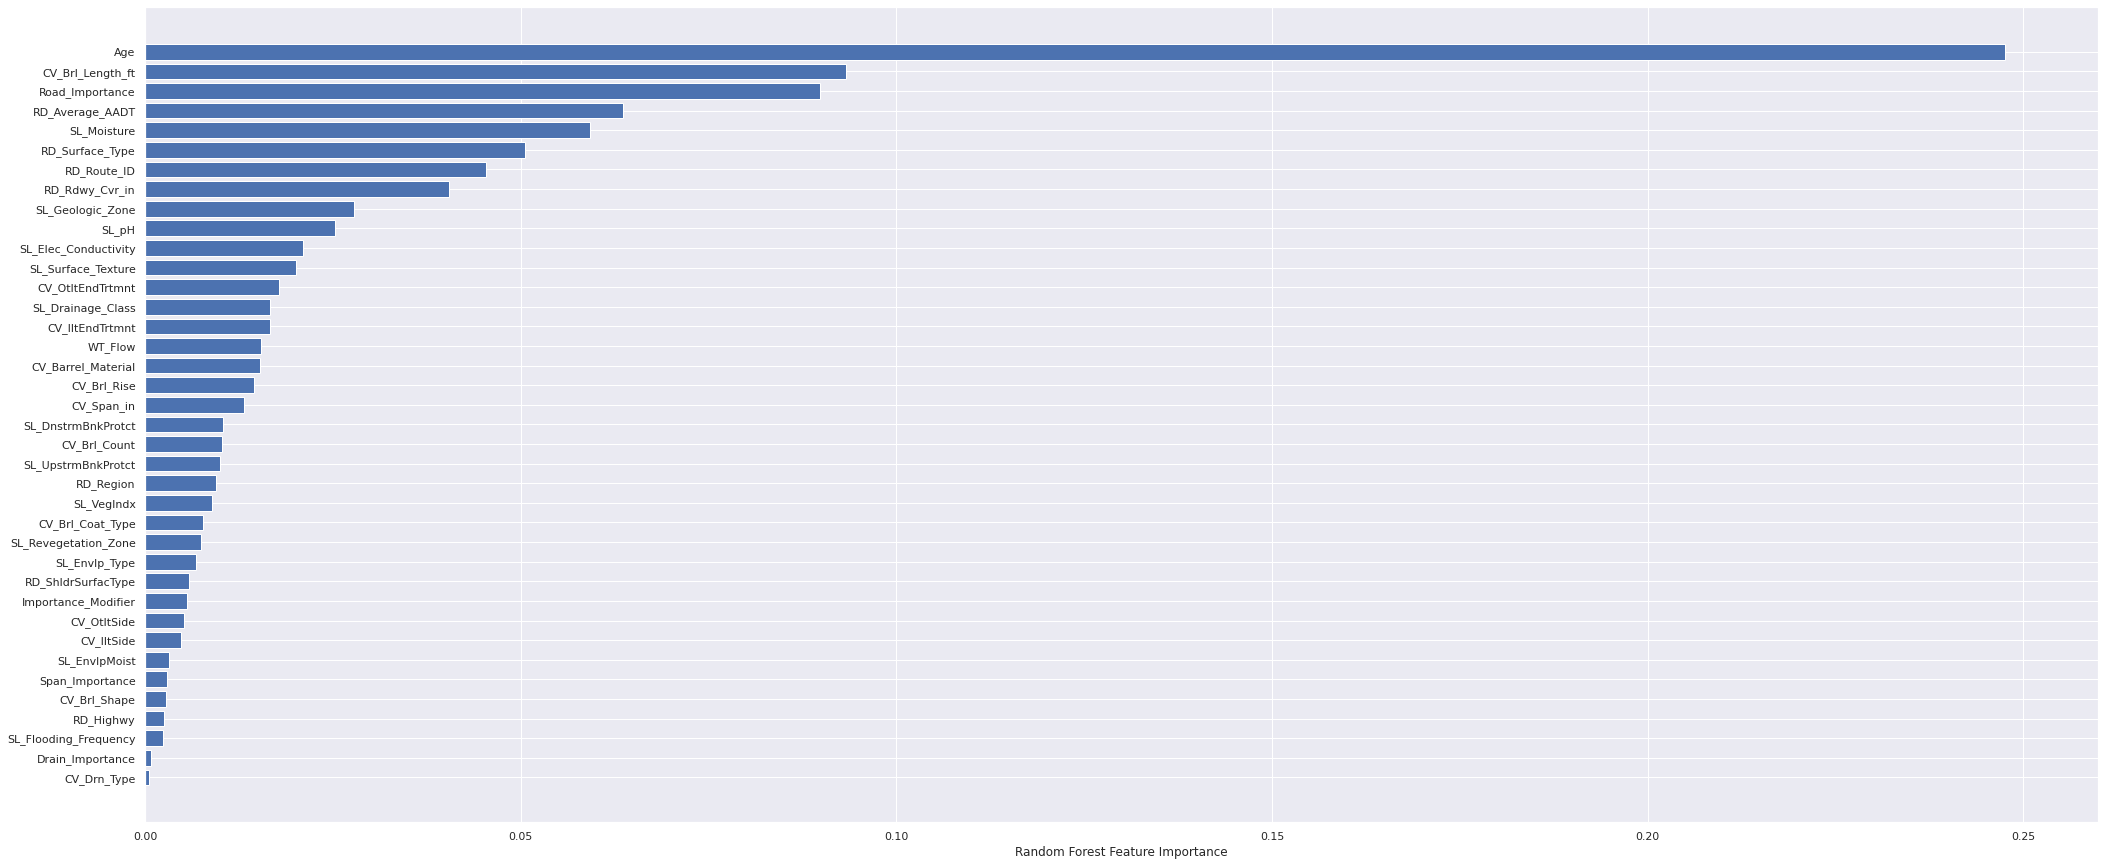

In [ ]:
# Find Feature Importance
X = UtahCulverts.drop(['Maint_Rtg','Brl_Rtng','Wtrwy_Rtng'], axis = 1)
y = UtahCulverts['Maint_Rtg']

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(UtahCulverts.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
least_important_feats1 = list(UtahCulverts.columns[sorted_idx])[0:8]
least_important_feats1

['Drain_Importance',
 'CV_Drn_Type',
 'RD_Highwy',
 'SL_EnvlpMoist',
 'SL_Flooding_Frequency',
 'Span_Importance',
 'CV_OtltSide',
 'CV_IltSide']

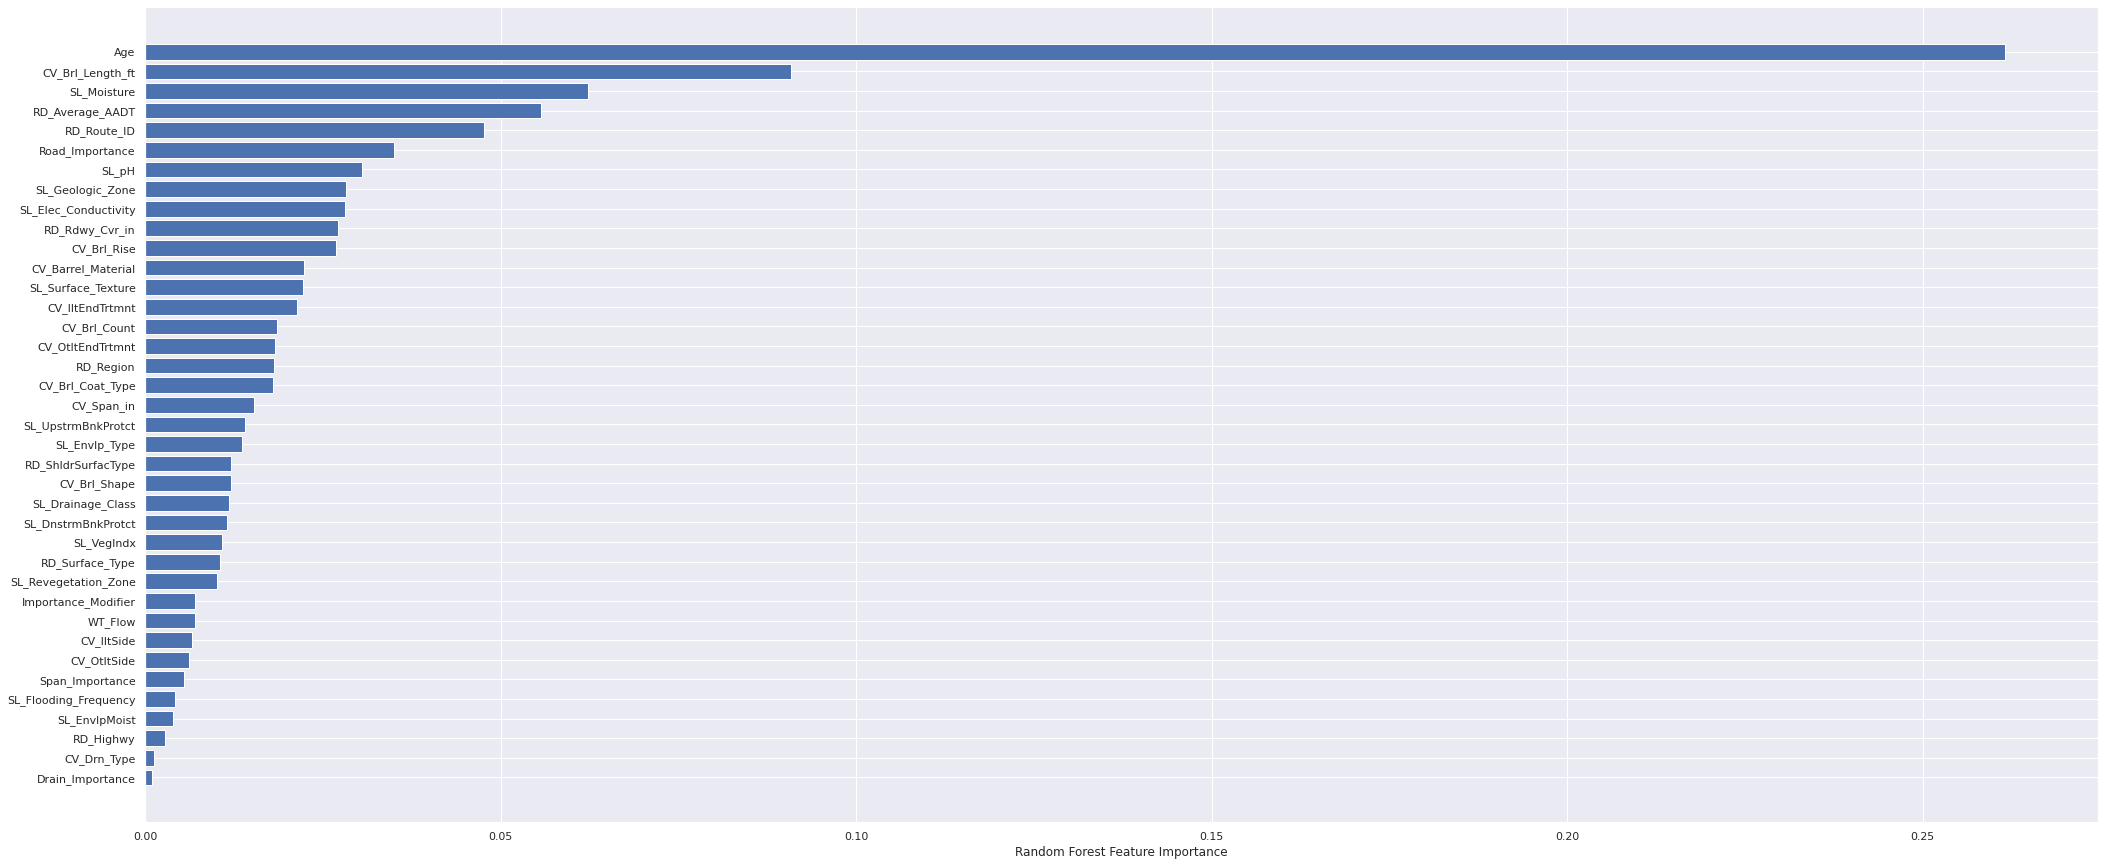

In [ ]:
# Find Feature Importance
X = UtahCulverts.drop(['Maint_Rtg','Brl_Rtng','Wtrwy_Rtng'], axis = 1)
y = UtahCulverts['Brl_Rtng']

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(UtahCulverts.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
least_important_feats2 = list(UtahCulverts.columns[sorted_idx])[0:8]
least_important_feats2

['CV_Brl_Shape',
 'Drain_Importance',
 'CV_Drn_Type',
 'Span_Importance',
 'SL_Flooding_Frequency',
 'CV_IltSide',
 'CV_Brl_Count',
 'RD_ShldrSurfacType']

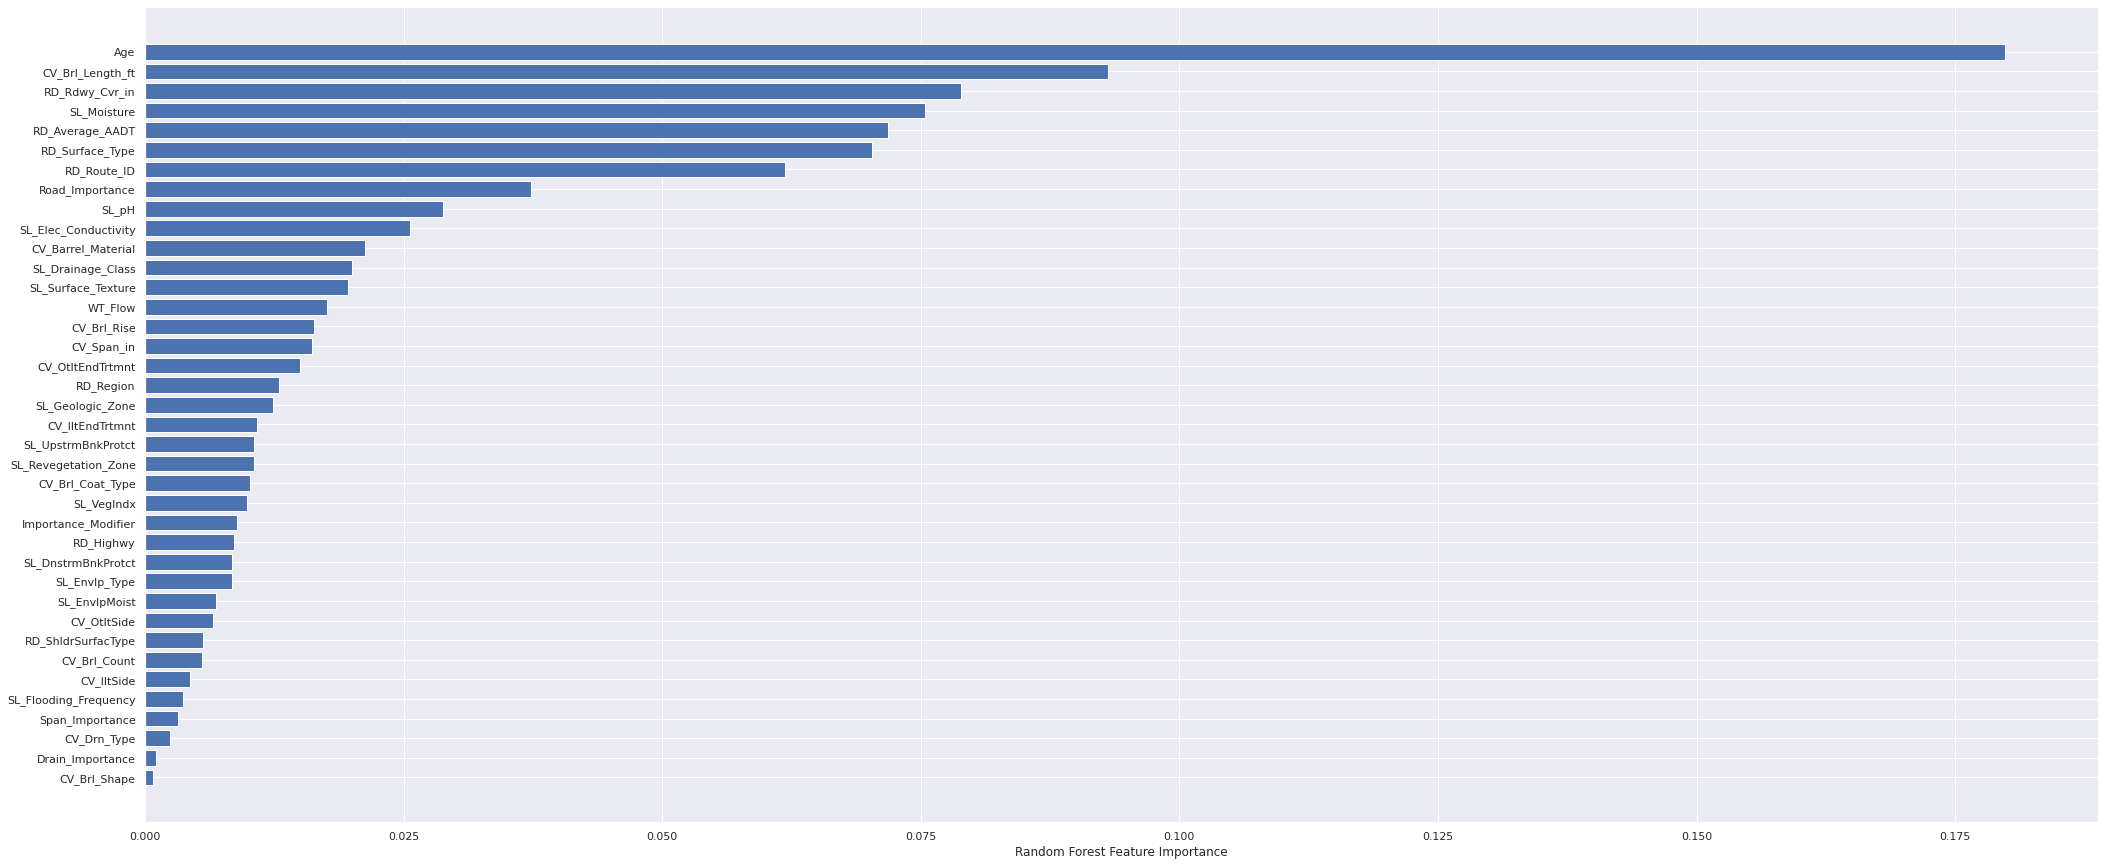

In [ ]:
# Find Feature Importance
X = UtahCulverts.drop(['Maint_Rtg','Brl_Rtng','Wtrwy_Rtng'], axis = 1)
y = UtahCulverts['Wtrwy_Rtng']

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(UtahCulverts.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
least_important_feats3 = list(UtahCulverts.columns[sorted_idx])[0:8]
least_important_feats3

In [ ]:
columns_to_drop = list(set.intersection(*map(set, [least_important_feats1, least_important_feats2, least_important_feats3])))
columns_to_drop

['Drain_Importance',
 'Span_Importance',
 'CV_Drn_Type',
 'CV_IltSide',
 'SL_Flooding_Frequency']

In [ ]:
# Remove Unimportant Features After Feature Selction using ExtraTreeModel 
UtahCulverts.drop(columns=columns_to_drop, inplace=True)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 <a list of 33 Text major ticklabel objects>)

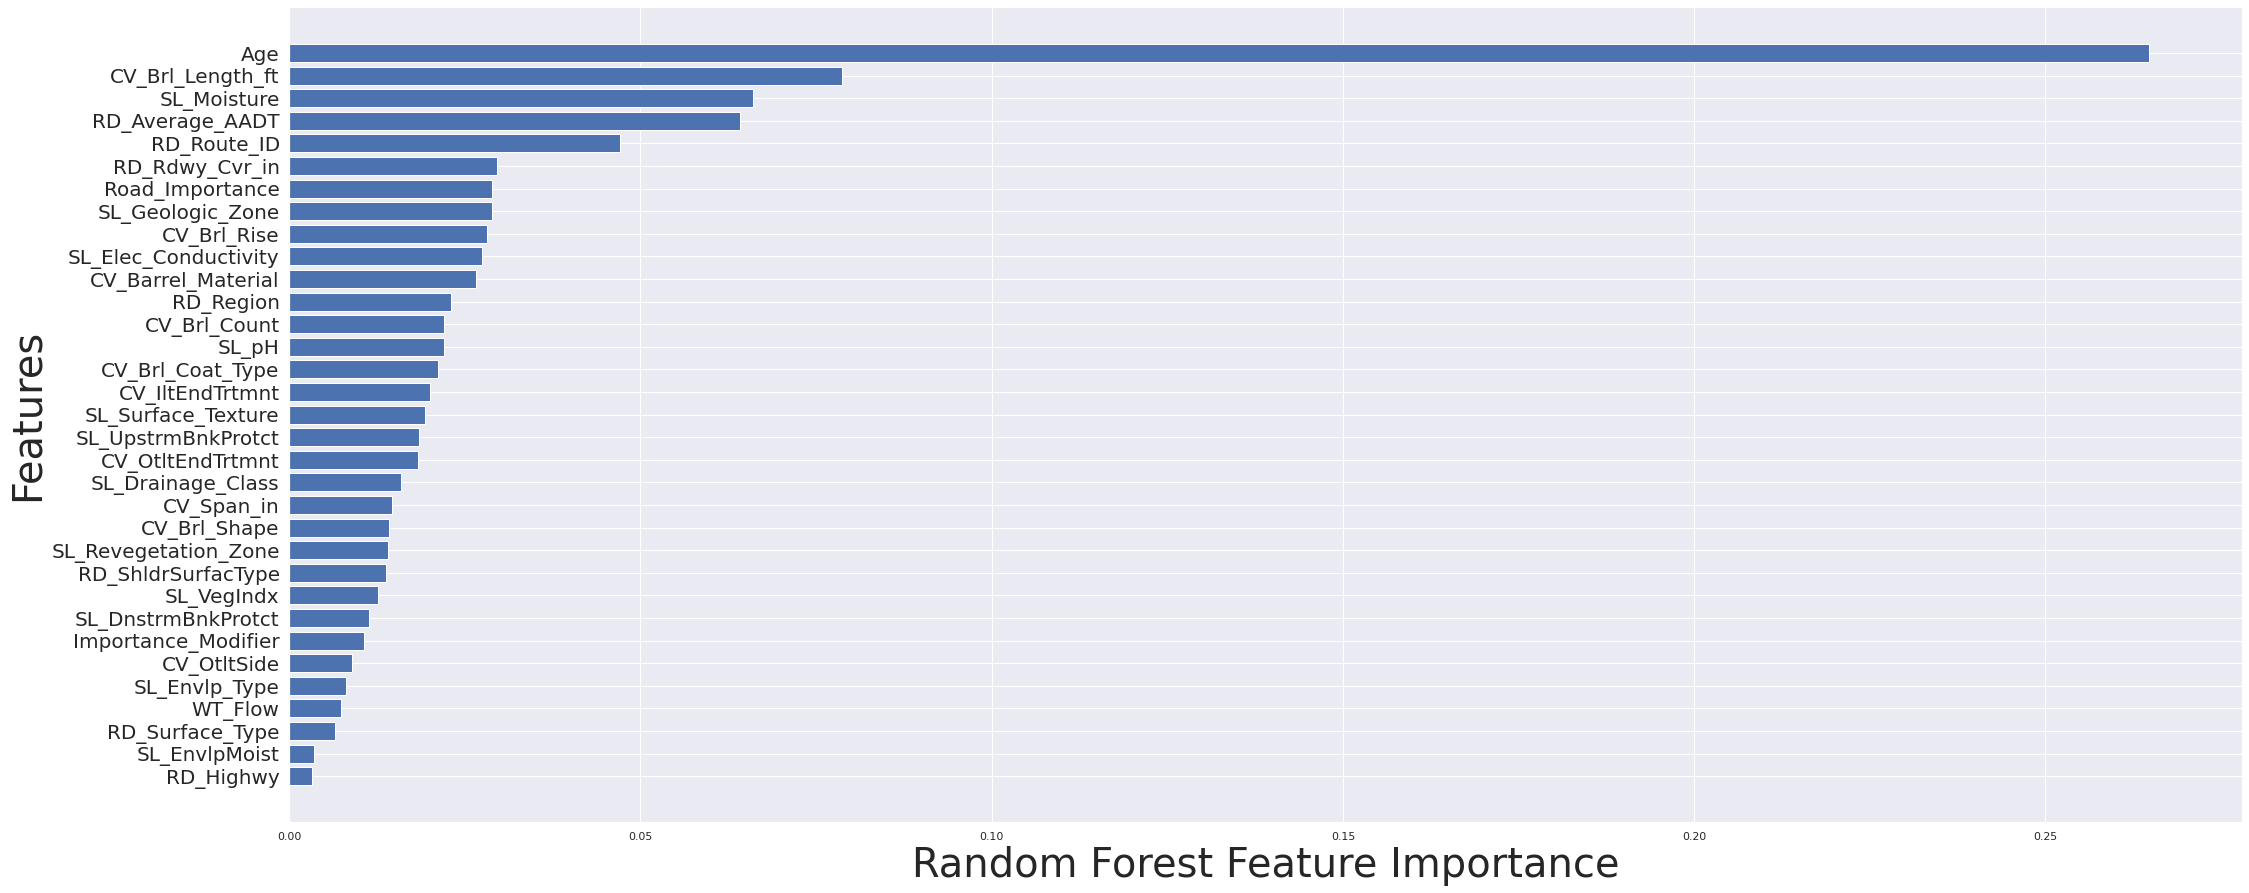

In [ ]:
# Final Feature Importances
X = UtahCulverts.drop(['Maint_Rtg','Brl_Rtng','Wtrwy_Rtng'], axis = 1)
y = UtahCulverts['Brl_Rtng']

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)
sorted_idx = rf_model.feature_importances_.argsort()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.barh(UtahCulverts.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance", size = 40)
plt.ylabel("Features", size = 40)
plt.yticks(size = 20)
